#### Fardin Rastakhiz @2023

In [1]:
import torch
from torch import nn
from torch_geometric.datasets import Planetoid
import os
from Scripts.Models.TextToKG.HelperModels.DepToken import DepTokenEmbedding
from Scripts.Models.Helpers.GraphLoader.GraphLoaderType1 import GraphLoaderType1
from Scripts.Models.Helpers.ModelsManager.ClassifierModelManager import ClassifierModelManager
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_geometric.utils import augmentation

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [3]:
# dataset = Planetoid(root=data_dir, name='Cora')
# dataset = Planetoid(root=data_dir, name='PubMed')
dataset = Planetoid(root=data_dir, name='CiteSeer')
data = dataset[0]

In [4]:
torch.max(data.edge_index)

tensor(3326)

In [5]:
data.x.shape

torch.Size([3327, 3703])

In [10]:
torch.arange(len(data.x))[254]

tensor(254)

In [6]:
augmentation.add_random_edge(data.edge_index, 0.2)[0].shape

torch.Size([2, 10925])

In [7]:
graphHandler = GraphLoaderType1(data.x, data.y, data.edge_index, 256, device)

RuntimeError: Legacy tensor constructor of the form torch.Tensor(tensor, device=device) is not supported.  Use torch.tensor(...) or torch.as_tensor(...) instead.

In [7]:
graphHandler.num_features

3703

In [20]:
data.y.shape

torch.Size([3327])

In [21]:
torch.unique(data.edge_index).shape

torch.Size([3279])

In [51]:
augmentation.add_random_edge(data.edge_index, 0.2)

(tensor([[   0,    1,    1,  ..., 1517, 3325, 1666],
         [ 628,  158,  486,  ..., 2143, 1539,  768]]),
 tensor([[ 210,  829, 1500,  ..., 1517, 3325, 1666],
         [3123, 3239, 2039,  ..., 2143, 1539,  768]]))

In [1]:
from collections import OrderedDict
dict1: OrderedDict[str, float] = OrderedDict()
dict1['aaa'] = 15.25
dict1['bbb'] = 32.423

In [3]:
for k in dict1:
    v = dict1[k]
    print(f'{k} : {v}')

aaa : 15.25
bbb : 32.423


In [37]:
torch.sum(augmentation.shuffle_node(data.x, training=False)[0], dim=0)

tensor([18., 77., 13.,  ...,  5.,  5.,  5.])

In [9]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [10]:
from sklearn.model_selection import train_test_split
from torch_geometric.utils import subgraph

In [11]:
classifier_model_manager = ClassifierModelManager(graphHandler, device)

<generator object Module.named_modules at 0x000001FE1F8DD460>
<generator object Module.named_modules at 0x000001FE1F8DD460>


In [13]:
classifier_model_manager.draw_summary()

+------------------------------+----------------------------+----------------+-----------+
| Layer                        | Input Shape                | Output Shape   | #Param    |
|------------------------------+----------------------------+----------------+-----------|
| GNNClassifier                | [4, 3703], [2, 2]          | [4, 6]         | 1,116,646 |
| ├─(encoder)Sequential_080179 | [4, 3703], [2, 2]          | [4, 256]       | 1,115,104 |
| │    └─(module_0)GCNConv     | [4, 3703], [2, 2]          | [4, 256]       | 948,224   |
| │    └─(module_1)ReLU        | [4, 256]                   | [4, 256]       | --        |
| │    └─(module_2)GCNConv     | [4, 256], [2, 2]           | [4, 128]       | 32,896    |
| │    └─(module_3)ReLU        | [4, 128]                   | [4, 128]       | --        |
| │    └─(module_4)GCNConv     | [4, 128], [2, 2]           | [4, 64]        | 8,256     |
| │    └─(module_5)ReLU        | [4, 64]                    | [4, 64]        | --        |

In [13]:
def create_cora_classifier_model(lr=0.01, weight_decay = 0.005, target_device='cpu', draw_summary=False):
    my_model = DepTokenEmbedding(input_feature=graphHandler.num_features, class_counts=graphHandler.num_classes)
    optimizer = torch.optim.Adam(my_model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_func = nn.CrossEntropyLoss()
    my_model.to(target_device)
    if draw_summary:
        nodes_x, nodes_y, edge_indices_test = graphHandler.get_test_data()
        nodes_x, nodes_y, edge_indices_test = my_model.extract_random_sub_edges_graph(2)
        print(summary(my_model,nodes_x, edge_indices_test))
    return my_model, optimizer, loss_func
my_model, optimizer, loss_func = create_cora_classifier_model(target_device=device, draw_summary=True)

<generator object Module.named_modules at 0x00000149EE21F290>
<generator object Module.named_modules at 0x00000149EE21F290>


AttributeError: 'GNNClassifier' object has no attribute 'extract_random_sub_edges_graph'

In [54]:
def train_for_cora_classification(target_model: DepTokenEmbedding, optimizer, loss_func, epoch_num):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    train_node_x, train_node_y, train_edges = graphHandler.get_train_data()
    test_node_x, test_node_y, test_edges = graphHandler.get_test_data()
    for i in tqdm(range(epoch_num)):
        model.train()
        optimizer.zero_grad()
        my_node, my_label, my_edges = extract_random_sub_edges_graph(train_edges, train_node_x, train_node_y, edge_count=500)
        y_hat: torch.Tensor = target_model(my_node, my_edges)
        loss = loss_func(F.one_hot(my_label, graphHandler.num_classes).float(), y_hat)
        loss.backward()
        optimizer.step()

        model.eval()

        loss_value = loss.item()
        train_losses.append(loss_value)
        accuracy = (torch.sum((y_hat.argmax(dim=1) == my_label).float())/len(my_label)).cpu().numpy()
        train_accuracies.append(accuracy)

        my_node, my_label, my_edges = extract_random_sub_edges_graph(test_edges, test_node_x, test_node_y, edge_count=1433)
        y_hat: torch.Tensor = target_model(my_node, my_edges)
        loss = loss_func(F.one_hot(my_label, graphHandler.num_classes).float(), y_hat)
        loss_value = loss.item()
        test_losses.append(loss_value)
        accuracy = (torch.sum((y_hat.argmax(dim=1) == my_label).float())/len(my_label)).cpu().numpy()
        test_accuracies.append(accuracy)

        # if i % 100 == 0:
        #     print(f'epoch {i}:\t acc={accuracy},\t loss={loss_value}')

    return train_losses, train_accuracies, test_losses, test_accuracies

In [55]:
from typing import List
def save_plot(data_array: List, labels: List, fig_name):
    for (d_array, d_label) in zip(data_array, labels):
        plt.plot(d_array, label=d_label)
    plt.legend()
    plt.title(fig_name)
    plt.savefig(f'./figures/{fig_name}.png')
    plt.close()

def draw_plot(data_array: List, labels: List, fig_name):
    for (d_array, d_label) in zip(data_array, labels):
        plt.plot(d_array, label=d_label)
    plt.legend()
    plt.title(fig_name)
    plt.show()
    plt.close()

In [56]:
# def find_best_parameters(epoch_num):
#     learning_rates = np.logspace(-6, -1, 12)
#     weight_decays = np.linspace(0.001,0.01, 3)
#     for lr in learning_rates:
#         for wd in weight_decays:
#             for i in range(2):
#                 target_model, optimizer, loss_func = create_cora_classifier_model(lr, wd, device)
#                 losses, accuracies = train_for_cora_classification(target_model, optimizer, loss_func, epoch_num)
#                 save_plot(losses, f'losses_lr={lr:>.6f}_wd={wd:>.4f} in iter={i}')
#                 save_plot(accuracies, f'accuracies_lr={lr:>.6f}_wd={wd:>.4f} in iter={i}')


In [57]:
# find_best_parameters(300)

In [58]:
model, my_optimizer, my_loss_func = create_cora_classifier_model(0.006, 0.001, device)
train_losses, train_accuracies, test_losses, test_accuracies = train_for_cora_classification(model, my_optimizer, my_loss_func, 5000)

100%|██████████| 5000/5000 [05:15<00:00, 15.87it/s]


In [64]:
save_plot([train_losses[:], test_losses[:]], ['train_losses', 'test_losses'], '_losses0')
save_plot([train_accuracies[:], test_accuracies[:]], ['train_accuracies', 'test_accuracies'], '_accuracies0')

In [62]:
my_optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
train_losses, train_accuracies, test_losses, test_accuracies = train_for_cora_classification(model, my_optimizer, my_loss_func, 2000)

100%|██████████| 2000/2000 [02:15<00:00, 14.73it/s]


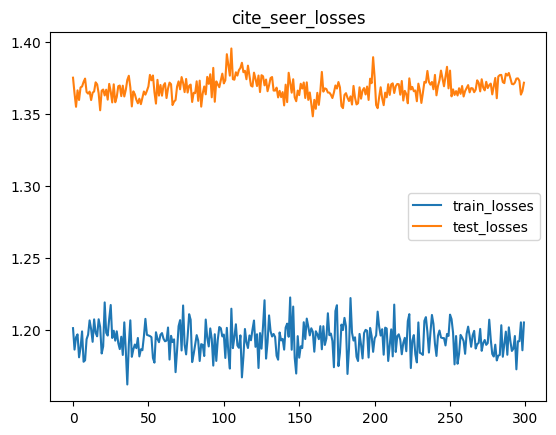

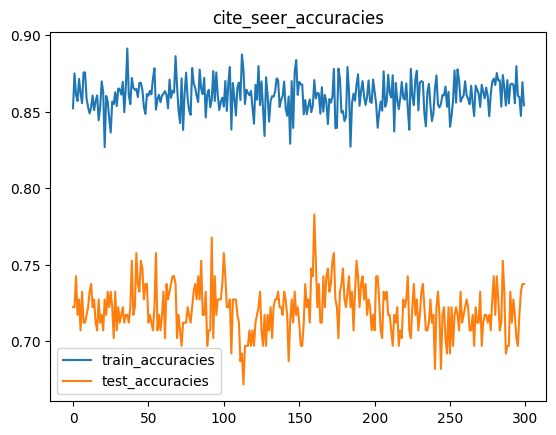

In [63]:
draw_plot([train_losses[-300:], test_losses[-300:]], ['train_losses', 'test_losses'], 'cite_seer_losses')
draw_plot([train_accuracies[-300:], test_accuracies[-300:]], ['train_accuracies', 'test_accuracies'], 'cite_seer_accuracies')

In [55]:
new_accuracies[-1]

array(0.89085317, dtype=float32)

In [36]:
torch.save(model, 'best_trained_model_citeseer_light.h5')